In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

In [212]:
# 데이터 로드 및 전처리
df = pd.read_csv('../data/거제도.csv', encoding='cp949')
df=df.set_index(pd.to_datetime(df.일시))
df = df[['평균 수온(°C)']]

df.loc[df['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan

df = df.dropna()
df

,평균 수온(°C)
일시,
2003-01-01,15.9
2003-01-02,16.6
2003-01-03,16.9
2003-01-04,16.7
2003-01-05,15.8
...,...
2022-12-27,15.7
2022-12-28,15.3
2022-12-29,15.0


c:\Users\admin\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  func(*args, **kwargs)
c:\Users\admin\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  func(*args, **kwargs)
c:\Users\admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


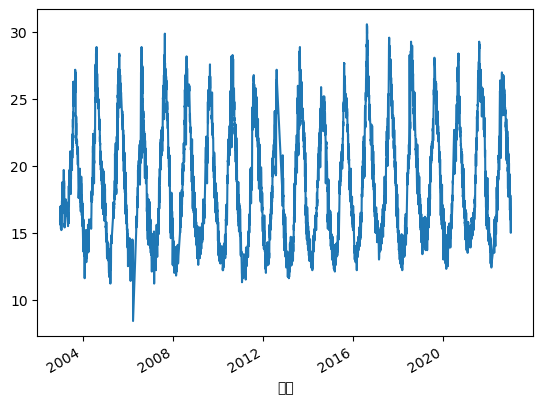

In [213]:
pig=df['평균 수온(°C)'].plot()

In [214]:
seq_length=365
batch_size=100

df=df[::-1]
train_size=int(len(df)*0.8)
train_set=df[0:train_size]
test_set=df[train_size-seq_length:]
print(train_set.shape, test_set.shape)

(5469, 1) (1733, 1)


In [215]:
# 데이터 스케일링
# Input scale

scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :])

scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1] = scaler_y.transform(train_set.iloc[:, [-1]])
test_set.iloc[:, -1] = scaler_y.transform(test_set.iloc[:, [-1]])


C:\Users\admin\AppData\Local\Temp\ipykernel_16824\311846543.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :])
C:\Users\admin\AppData\Local\Temp\ipykernel_16824\311846543.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :])
C:\Users\admin\AppData\Local\Temp\ipykernel_16824\311846543.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [216]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(125)
if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [217]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []

    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [[-1]]]
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [218]:
trainX, trainY=build_dataset(np.array(train_set), seq_length)
testX, testY=build_dataset(np.array(test_set), seq_length)

In [219]:
trainX_tensor=torch.FloatTensor(trainX)
trainY_tensor=torch.FloatTensor(trainY)

testX_tensor=torch.FloatTensor(testX)
testY_tensor=torch.FloatTensor(testY)

train_dataset=TensorDataset(trainX_tensor, trainY_tensor)
train_dataloader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset=TensorDataset(testX_tensor, testY_tensor)
test_dataloader=DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [220]:
data_dim=1
hidden_dim=10
output_dim=1
learning_rate=0.1
n_epochs=100

In [221]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim=hidden_dim
        self.seq_len=seq_len
        self.output_dim=output_dim
        self.layers=layers

        self.lstm=nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc=nn.Linear(hidden_dim, output_dim, bias=True)

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden=(
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim))

    def forward(self, x):
        x, _status=self.lstm(x)
        x=self.fc(x[:, -1])
        return x

In [222]:
def train_model(model, train_df, num_epochs=3000, lr=None, verbos=10,patience=10):
    criterion=nn.MSELoss().to(device)
    optimizer=optim.Adam(model.parameters(), lr=learning_rate)
    nb_epochs=num_epochs

    # epoch마다 loss 저장
    train_hist=np.zeros(n_epochs)

    for epoch in range(nb_epochs):
        avg_cost=0
        total_batch=len(train_df)

        for batch_idx, samples in enumerate(train_df):
            x_train, y_train=samples

            model.reset_hidden_state()

            outputs=model(x_train)

            loss=criterion(outputs, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch]=avg_cost

        if epoch % verbos==0:
            print('Epoch:', '%04d' %(epoch), 'train loss','{:.4f}'.format(avg_cost))

        
        if (epoch % patience ==0) & (epoch !=0):
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Earay Stopping')
                break
    
    return model.eval(), train_hist

c:\Users\admin\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([100, 1, 1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0000 train loss 0.1237
Epoch: 0020 train loss 0.1114

 Earay Stopping


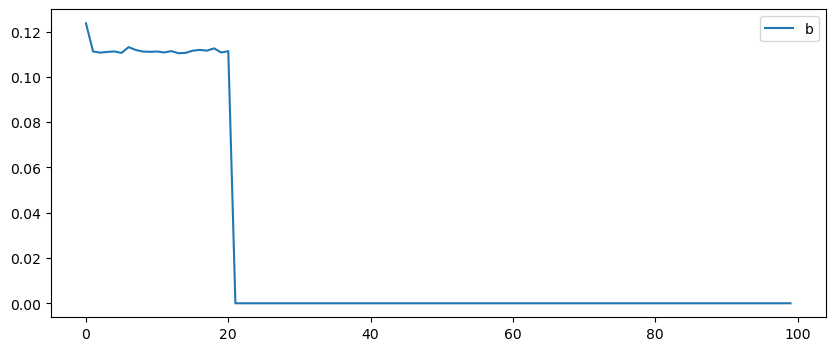

In [223]:
net=Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model, train_hist=train_model(net, train_dataloader, num_epochs=n_epochs, 
                              lr=learning_rate, verbos=20, patience=10)

fig=plt.figure(figsize=(10, 4))
plt.plot(train_hist, label='Training loss')
plt.legend('best')
plt.show()

In [224]:
# 모델 저장
PATH='../data/lstm_rjwp_KS.pth'
torch.save(model.state_dict(), PATH)

# 모델 불러오기
model=Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

Net(
  (lstm): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [225]:
with torch.no_grad():
    pred=[]
    for pr in range(len(testX_tensor)):
        model.reset_hidden_state()

        predicted=model(torch.unsqueeze(testX_tensor[pr],0))
        predicted=torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse=scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    # testY_inverse=scaler_y.inverse_transform(testY_tensor)
    testY_reshaped = testY_tensor.reshape(-1, output_dim)
    testY_inverse = scaler_y.inverse_transform(testY_reshaped)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE:', MAE(pred_inverse, testY_inverse))

MAE SCORE: 3.539474901593322


In [226]:
print(testY_inverse.shape)
print(pred_inverse)
print(model.state_dict())

(1368, 1)
[[17.03364075]
 [17.15612233]
 [17.18006324]
 ...
 [17.20266168]
 [17.20477318]
 [17.20398518]]
OrderedDict([('lstm.weight_ih_l0', tensor([[-0.4923],
        [-0.5237],
        [-0.4077],
        [-0.8254],
        [-0.4091],
        [-0.2455],
        [-0.2217],
        [-1.1426],
        [-0.4736],
        [-0.8751],
        [-0.2775],
        [-0.3064],
        [-0.3878],
        [-0.7264],
        [-0.3584],
        [-0.4948],
        [-0.1875],
        [-0.8901],
        [-0.1846],
        [-1.0859],
        [ 0.3599],
        [ 0.5414],
        [-1.0952],
        [-0.4223],
        [ 0.1617],
        [-0.1487],
        [ 0.3258],
        [ 0.7341],
        [-0.1008],
        [ 0.1835],
        [-0.5243],
        [-0.4957],
        [-0.2684],
        [-0.8679],
        [-0.6656],
        [-0.5650],
        [-0.3487],
        [-1.1282],
        [-0.6439],
        [-1.2443]])), ('lstm.weight_hh_l0', tensor([[ 3.3275e-01,  5.7427e-01, -5.2829e-01, -3.4473e-01,  6.5646e-01,


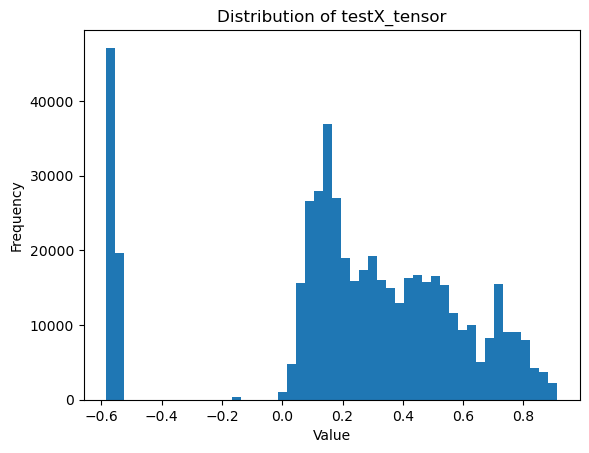

In [227]:
import matplotlib.pyplot as plt

# testX_tensor의 분포 확인
plt.hist(testX_tensor.flatten(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of testX_tensor')
plt.show()

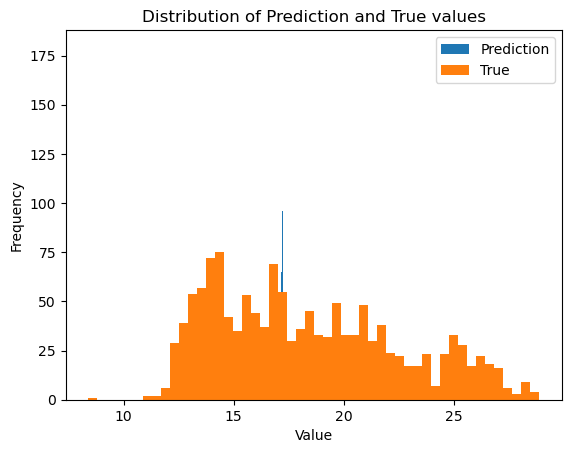

In [228]:
import matplotlib.pyplot as plt

# 예측값과 실제값의 분포 확인
plt.hist(pred_inverse.flatten(), bins=50, label='Prediction')
plt.hist(testY_inverse.flatten(), bins=50, label='True')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction and True values')
plt.legend()
plt.show()

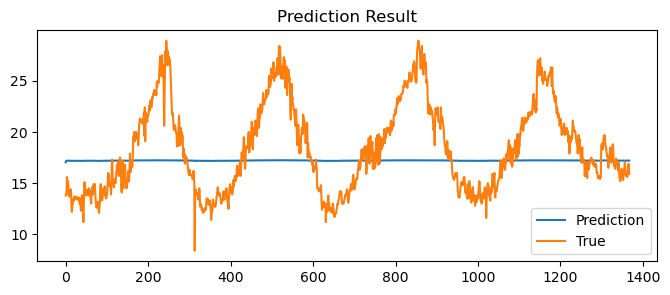

In [229]:
fig = plt.figure(figsize=(8, 3))
plt.plot(pred_inverse, label='Prediction')
plt.plot(testY_inverse, label='True')
plt.legend()
plt.title('Prediction Result')
plt.show()

In [230]:
class GRU(nn.Module) :
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(GRU, self).__init__()
        self.num_classes = output_dim
        self.num_layers = layers
        self.input_size = input_dim
        self.hidden_size = hidden_dim
        self.seq_length = seq_len
    
        self.gru = nn.GRU(input_size=input_dim,hidden_size=hidden_dim,
                         num_layers=layers,batch_first=True)
        self.fc_1 = nn.Linear(hidden_dim, 128)
        self.fc = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x) :
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [231]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # seq별 hidden state reset
            #model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

c:\Users\admin\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([100, 1, 1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0000 train loss : 0.1741
Epoch: 0020 train loss : 0.1110

 Early Stopping


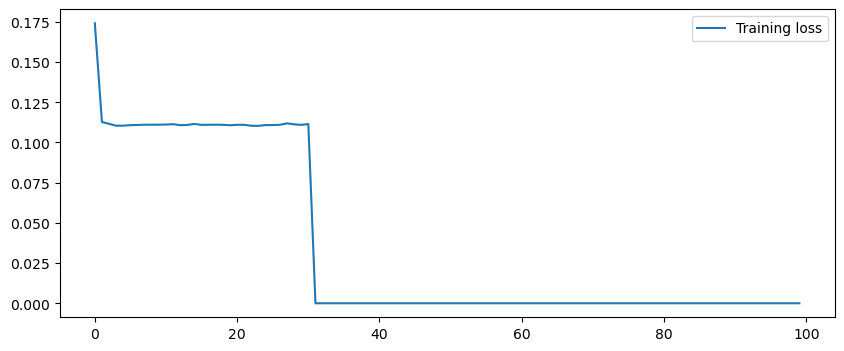

In [232]:
net = GRU(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model, train_hist = train_model(net, train_dataloader, num_epochs = n_epochs, 
                                lr = learning_rate, verbose = 20, patience = 10)
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [233]:
# 모델 저장    
PATH_GRU = "../data/GRU_rjwp_01.pth"
torch.save(model.state_dict(), PATH_GRU)

# 불러오기
model = GRU(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH_GRU), strict=False)
model.eval()

GRU(
  (gru): GRU(1, 10, batch_first=True)
  (fc_1): Linear(in_features=10, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [234]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        #model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_reshaped = testY_tensor.reshape(-1, output_dim)
    testY_inverse = scaler_y.inverse_transform(testY_reshaped)
    # testY_inverse = scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

MAE SCORE :  3.5480902267231906


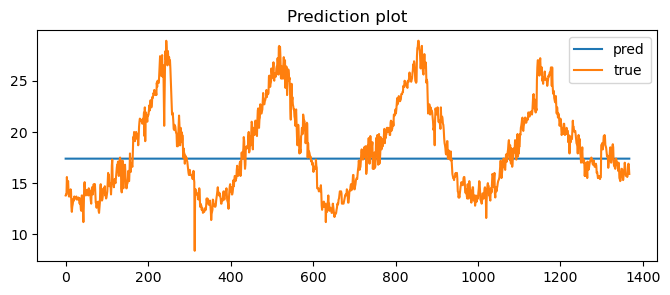

In [235]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Prediction plot")
plt.legend()
plt.show()